In [63]:
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor, Pool
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from itertools import product,chain
%matplotlib inline

In [120]:

train = pd.read_csv("train_cat1.csv")
test = pd.read_csv("test_cat1.csv")

In [121]:
#Remomve logerror
drop_columns = ['logerror']
train_features = []

for c in train.columns:
    if c not in drop_columns:
        train_features.append(c)
         
print(train_features)
        


['parcelid', 'airconditioningtypeid', 'bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid', 'calculatedbathnbr', 'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'finishedsquarefeet15', 'finishedsquarefeet50', 'fips', 'fireplacecnt', 'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet', 'poolcnt', 'pooltypeid7', 'propertylandusetypeid', 'rawcensustractandblock', 'regionidcity', 'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt', 'threequarterbathnbr', 'unitcnt', 'numberofstories', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'assessmentyear', 'landtaxvaluedollarcnt', 'taxamount', 'censustractandblock', 'transaction_year', 'transaction_month', 'transaction_day', 'transaction_quarter', 'New_YearsSinceBuild']


In [122]:
###
### Define categorical feature indices
###

cat_feature_inds = []
for i, c in enumerate(train_features):
    if not 'parcelid' in c \
        and not 'squarefeet' in c \
        and not 'sqft' in c \
        and not 'cnt' in c \
        and not 'nbr' in c \
        and not 'amount' in c \
        and not 'sum' in c \
        and not 'transaction' in c \
        and not 'New_' in c \
        and not 'lat' in c \
        and not 'long' in c \
        and not 'raw' in c \
        and not 'number' in c:
            
        cat_feature_inds.append(i)
        
print("Cat features are: %s" % [train_features[ind] for ind in cat_feature_inds])

Cat features are: ['airconditioningtypeid', 'buildingqualitytypeid', 'fips', 'heatingorsystemtypeid', 'pooltypeid7', 'propertylandusetypeid', 'regionidcity', 'regionidcounty', 'regionidneighborhood', 'regionidzip', 'assessmentyear', 'censustractandblock']


In [123]:
train_x = train[train_features]
train_y = train.logerror

X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, test_size=0.15, random_state=42)

In [124]:
X_test = test[train_features]

In [91]:
def score(params):
    params['depth'] = int(params['depth'])
    params['iterations'] = int(params['iterations'])
    params['l2_leaf_reg'] = int(params['l2_leaf_reg'])
    model = CatBoostRegressor(iterations=params['iterations'], learning_rate=params['learning_rate'], depth=params['depth'],loss_function='MAE',eval_metric='MAE')
    #model = CatBoostRegressor()
    model.fit(X_train, y_train,cat_features=cat_feature_inds)

    predictions = model.predict(X_val)
    
    score = mean_absolute_error(y_val, predictions)    
    print("############### Score: {0}".format(score))
    print("############### Params: ", params)
    return {'loss': score, 'status': STATUS_OK}

In [94]:
def optimize(trials):
    space = {
          'depth': hp.quniform('depth', 4, 8, 1),
          'iterations':hp.quniform('iterations', 300, 700, 200),
          'learning_rate':hp.quniform('learning_rate', 0.01,0.05, 0.01), 
          'l2_leaf_reg':hp.quniform('l2_leaf_reg',2,4,1)
          
         }
             
    best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=50)
    print (best)


In [95]:
trials = Trials()
optimize(trials)

0: learn: 0.06918058	total: 242ms	remaining: 2m 25s
1: learn: 0.06902342	total: 517ms	remaining: 2m 34s
2: learn: 0.06894751	total: 581ms	remaining: 1m 55s
3: learn: 0.0688611	total: 803ms	remaining: 1m 59s
4: learn: 0.06879317	total: 1.01s	remaining: 2m
5: learn: 0.06874715	total: 1.31s	remaining: 2m 9s
6: learn: 0.06871983	total: 1.43s	remaining: 2m 1s
7: learn: 0.06868812	total: 1.67s	remaining: 2m 3s
8: learn: 0.06864946	total: 1.87s	remaining: 2m 2s
9: learn: 0.06861216	total: 2.12s	remaining: 2m 4s
10: learn: 0.06858718	total: 2.44s	remaining: 2m 10s
11: learn: 0.06855702	total: 2.63s	remaining: 2m 8s
12: learn: 0.06853517	total: 2.85s	remaining: 2m 8s
13: learn: 0.06852534	total: 3.1s	remaining: 2m 9s
14: learn: 0.06850933	total: 3.32s	remaining: 2m 9s
15: learn: 0.06850281	total: 3.47s	remaining: 2m 6s
16: learn: 0.06849692	total: 3.69s	remaining: 2m 6s
17: learn: 0.06848754	total: 3.9s	remaining: 2m 5s
18: learn: 0.06848092	total: 4.09s	remaining: 2m 4s
19: learn: 0.06846524	t

In [125]:
model = CatBoostRegressor(iterations=500, learning_rate=0.03, depth=6,loss_function='MAE',eval_metric='MAE',calc_feature_importance=True)
model.fit(X_train, y_train,cat_features=cat_feature_inds)

y_pred = model.predict(X_test)

0: learn: 0.06920561	total: 88.9ms	remaining: 44.4s
1: learn: 0.06905092	total: 302ms	remaining: 1m 15s
2: learn: 0.06895756	total: 472ms	remaining: 1m 18s
3: learn: 0.068888	total: 667ms	remaining: 1m 22s
4: learn: 0.06881957	total: 825ms	remaining: 1m 21s
5: learn: 0.06878694	total: 933ms	remaining: 1m 16s
6: learn: 0.06875525	total: 1.06s	remaining: 1m 14s
7: learn: 0.06872917	total: 1.28s	remaining: 1m 18s
8: learn: 0.06869137	total: 1.42s	remaining: 1m 17s
9: learn: 0.068658	total: 1.6s	remaining: 1m 18s
10: learn: 0.06864209	total: 1.78s	remaining: 1m 19s
11: learn: 0.06861247	total: 2.01s	remaining: 1m 21s
12: learn: 0.06859148	total: 2.22s	remaining: 1m 23s
13: learn: 0.06857766	total: 2.43s	remaining: 1m 24s
14: learn: 0.06855445	total: 2.63s	remaining: 1m 25s
15: learn: 0.0685391	total: 2.84s	remaining: 1m 25s
16: learn: 0.06853131	total: 3.02s	remaining: 1m 25s
17: learn: 0.06852333	total: 3.25s	remaining: 1m 27s
18: learn: 0.06850911	total: 3.39s	remaining: 1m 25s
19: learn

In [119]:
submission = pd.DataFrame()
submission["parcelid"] = test['parcelid'].copy()
submission["logerror"] = test['logerror'].copy()
submission["prediction"] = y_pred
ground_truth = submission["logerror"].values
predictions = submission["prediction"].values
abs_error = abs(ground_truth - predictions)
submission["abs_error"] = abs_error

# Calculate mean absolute error
mae = mean_absolute_error(ground_truth, predictions)
print("Mean Absolute Error: {}".format(mae))

Mean Absolute Error: 0.067836576628597


In [23]:
filename = 'cat_preds_mod2.csv'
print(filename)
submission.to_csv(filename,index=False)

cat_preds_mod2.csv


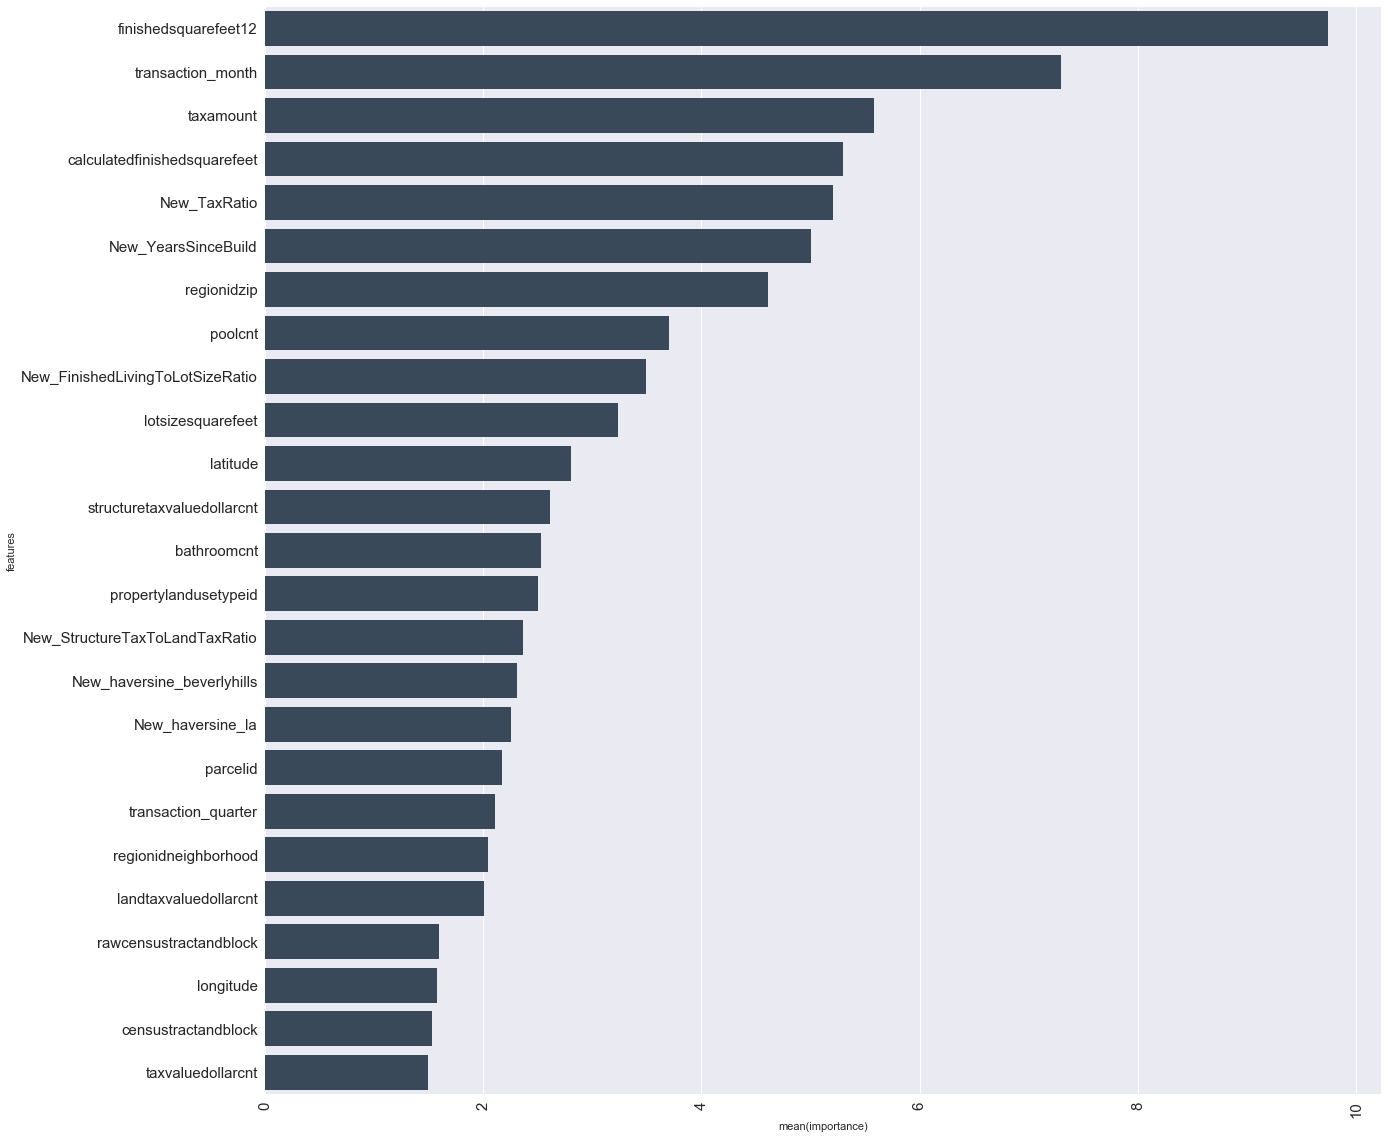

In [42]:
###
### Plot feature importance on CatBoost model
###

pool = Pool(X_test)
feature_importance = model.get_feature_importance(X=X_test,y=y_pred,cat_features=cat_feature_inds)
features = pd.DataFrame()
features['features'] = X_test.columns.values
features['importance'] = feature_importance
features.sort_values(by=['importance'],ascending=False,inplace=True)
fig,ax= plt.subplots()
fig.set_size_inches(20,20)
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)
sn.barplot(data=features.head(25),x="importance",y="features",ax=ax,orient="h",color="#34495e")

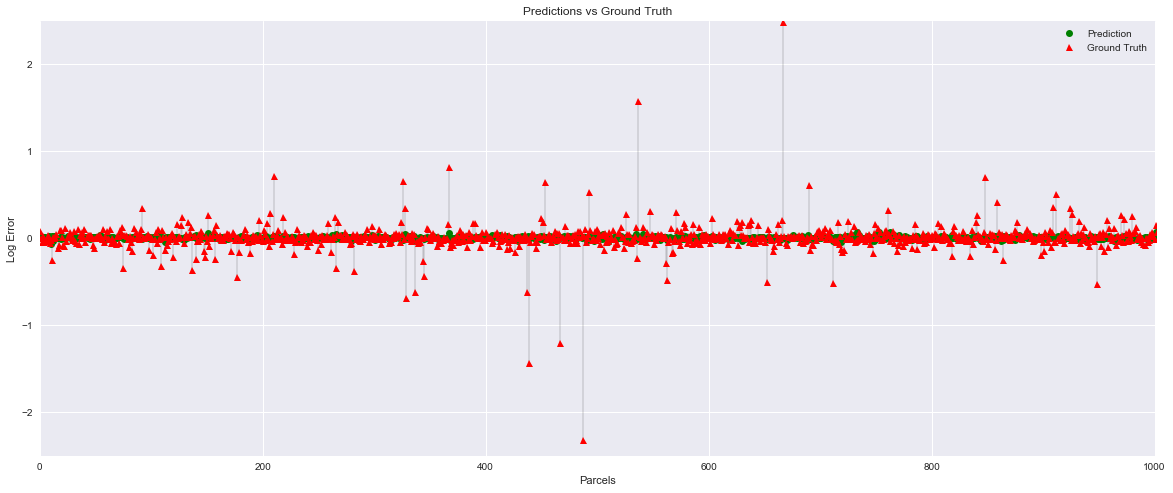

In [50]:
###
### Plot CatBoost predicted log error vs ground truth 
###

plt.rcParams['legend.numpoints'] = 1


fig, ax = plt.subplots(figsize=(20,8))

 
for i in range(1000):
    ax.plot([i,i],[predictions[i], ground_truth[i]], c="k", linewidth=0.2)
ax.plot(predictions,'o', label='Prediction', color = 'g')
ax.plot(ground_truth,'^', label='Ground Truth', color = 'r' )

ax.set_xlim((0,1000+1))
ax.set_ylim((-2.5,2.5))
plt.xlabel('Parcels')
plt.ylabel('Log Error')
plt.title('Predictions vs Ground Truth')

plt.legend()             
plt.show()